In [1]:
import calendar
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#from mpl_toolkits.basemap import Basemap as Basemap
import networkx as nx
import numpy as np
import pandas as pd
import requests
import zipfile

## Recolección de datos

Comenzamos definiendo el URL del archivo que contiene los datos abiertos sobre los casos de coronavirus en México. Esta URL se almacena en un `string` llamado `url`.

In [189]:
url = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip'

A continuación descargamos el archivo usando la librería `requests` y lo guardamos en el disco con el nombre `datos.zip`:

In [190]:
# Descargar archivo:
archivo_obj = requests.get(url, allow_redirects = True)

# Guardar en el disco:
archivo = open('datos.zip', 'wb')
archivo.write(archivo_obj.content)
archivo.close()

El archivo descargado tiene formato `zip`, por lo que es necesario descomprimirlo. Esto se puede hacer con la librería `zipfile`:

In [191]:
archivo_zip = zipfile.ZipFile('datos.zip', 'r')
archivo_zip.extractall()
archivo_zip.close()

Sabemos que el contenido del archivo comprimido es un archivo `csv`, pero no conocemos su nombre. Por lo tanto, usamos la librería `glob` para localizar en el directorio actual un archivos `csv` para cargarlo en `pandas`. Un problema potencial con este método es que si existen varios archivos `csv` en el directorio, cargará sólo el primero que encuentre. Por eso es importante asegurarse previamente de que no existan archivos de ese tipo antes de ejecutar el código. El nombre del archivo `csv` encontrado es un `string` que se almacenará en la variable `nombre_datos`:

In [192]:
nombre_datos = [n for n in glob.glob("*.csv") if n != 'confirmados.csv'][0]

## Procesamiento de los datos

Una vez que se tiene el nombre del archivo `csv` con los datos, se puede importar directamente a `pandas`. El `DataFrame` donde se almacenará se llama `datos`:

In [193]:
datos = pd.read_csv(nombre_datos)

Obtenemos el número de registros en la base de datos:

In [194]:
print(len(datos))

6774089


Para comprender la etsructura de la base de datos, obtenemos los nombres y tipos de las columnas del `DataFrame`:

In [195]:
print(datos.dtypes)

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

Algunas columnas son de tipo `object`, por lo que mostramos los valores de la primera fila para tener una idea del tipo de información que contienen:

In [196]:
print(datos.iloc[0])

FECHA_ACTUALIZACION      2021-05-11
ID_REGISTRO                  z482b8
ORIGEN                            1
SECTOR                           12
ENTIDAD_UM                        9
SEXO                              2
ENTIDAD_NAC                       9
ENTIDAD_RES                       9
MUNICIPIO_RES                    12
TIPO_PACIENTE                     1
FECHA_INGRESO            2020-10-16
FECHA_SINTOMAS           2020-10-16
FECHA_DEF                9999-99-99
INTUBADO                         97
NEUMONIA                          2
EDAD                             41
NACIONALIDAD                      1
EMBARAZO                         97
HABLA_LENGUA_INDIG               99
INDIGENA                         99
DIABETES                          2
EPOC                              2
ASMA                              2
INMUSUPR                          2
HIPERTENSION                      2
OTRA_COM                          2
CARDIOVASCULAR                    2
OBESIDAD                    

Se observa lo siguiente: `ID_REGISTRO` es un código alfanumérico asociado a cada caso, mientras que `FECHA_ACTUALIZACION`, `FECHA_INGRESO`, `FECHA_SINTOMAS` y `FECHA_DEF` son cadenas de texto que representan fechas, por lo que es conveniente convertirlas al tipo de datos `datetime`. Sin embargo, se observa que en el caso del registro mostrado, el valor de `FECHA_DEF` es `9999-99-99`, que es una fecha inválida que indica que el paciente no murió. Para poder transformarlo al tipo `datetime`, es necesario que sea una fecha consistente, por lo que se cambiará (en todos los casos) a la mayor fecha que admita `pandas`. Esta fecha máxima se almacenará como un `string` en la variable `fecha_max`:

In [197]:
fecha_max = str(pd.Timestamp.max.date())
print(fecha_max)

2262-04-11


Reemplazar todas las ocurrencias de `9999-99-99` por `fecha_max`:

In [198]:
datos = datos.replace('9999-99-99', fecha_max)

Volvemos a verificar el primer registro para ver si `FECHA_DEF` tiene el formato correcto:

In [199]:
print(datos.iloc[0]['FECHA_DEF'])

2262-04-11


Como se cambió exitosamente, es posible modificar el tipo de datos de las columnas que contienen textos representando fechas al tipo `datetime` sin errores:

In [200]:
# Almacenamos los nombres de las columnas a transformar en fechas en la lista 'col2date':
col2date = [
    'FECHA_ACTUALIZACION',
    'FECHA_INGRESO',
    'FECHA_SINTOMAS',
    'FECHA_DEF'
]

# Transformamos el tipo de datos columna a columna:
for columna in col2date:
    datos[columna] = pd.to_datetime(datos[columna])

Verificamos que las columnas de fechas contengan valores de tipo `datetime`:

In [201]:
print(datos[col2date].dtypes)

FECHA_ACTUALIZACION    datetime64[ns]
FECHA_INGRESO          datetime64[ns]
FECHA_SINTOMAS         datetime64[ns]
FECHA_DEF              datetime64[ns]
dtype: object


Lo cual confirma que la transformación fue exitosa.

## Extracción de los datos relevantes

Dado que el objetivo del trabajo es construir redes estáticas para cada día con base en el número de casos confirmados por estados, las variables de interés son `ENTIDAD_UM` (estado donde la persona recibió atención médica, esto es un mejor indicador de la incidencia geográfica de casos que el estado de origen o el estado de residencia habitual) y `CLASIFICACION_FINAL`. Esta última variable, de acuerdo con el [diccionario de datos](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico) proporcionado por el Gobierno de México, toma los siguientes valores:

| Valor | Significado                                                        |
|-------|--------------------------------------------------------------------|
| 1     | Caso de COVID-19 confirmado por asociación clínica epidemiológica. |
| 2     | Caso de COVID-19 confirmado por comité de dictaminación.           |
| 3     | Caso de SARS-COV-2 confirmado.                                     |
| 4     | Inválido por laboratorio.                                          |
| 5     | No realizado por laboratorio.                                      |
| 6     | Caso sospechoso.                                                   |
| 7     | Negativo a SARS-COV-2.                                             |

Por lo tanto, se cosiderará que un caso está confirmado cuando tiene como valor de la variable `CLASIFICACION_FINAL` al alguno de los números 1, 2 o 3. El primer objetivo es obtener, para cada día y para cada estado, el número de casos confirmados (acumulados).

Creamos un `DataFrame` llamado `confirmados`, que contendrá las siguientes columnas: `fecha`, `estado` y `casos`:

In [202]:
confirmados = pd.DataFrame(columns = ['fecha', 'estado', 'casos'])
print(confirmados)

Empty DataFrame
Columns: [fecha, estado, casos]
Index: []


En primer lugar extraemos los valores únicos de la variable `FECHA_INGRESO`. Estos serán los valores de la columna `fecha` en en `DataFrame` `confirmados`. Estas fechas se almacenan en un `array` llamado `fechas`:

In [203]:
fechas = np.sort(datos['FECHA_INGRESO'].unique())

Se hace lo mismo con la variable `ENTIDAD_UM` para extraer sus valores únicos, que se almacenan en el `array` `estados`:

In [204]:
estados = np.sort(datos['ENTIDAD_UM'].unique())

A continuación se llenan las filas del `DataFrame` `confirmados` construido anteriormente.

<mark>Nota importante</mark>. Debido a que el código para llevar a cabo esto tarda varios minutos (alrededor de 15 en una Mac), se establece la variable booleana `ejecutar`.
* En caso de que la variable `ejecutar` tenga el valor `True`, el código se ejecutará y el `DataFrame` resultante se guardará en un archivo llamado `confirmados.csv` para ser usado en el futuro sin necesidad de volver a ejecutar el código.
* En caso de que la variable `ejecutar` tenga el valor `False`, el script tratará de cargar los contenidos del archivo `confirmados.csv` existente en el `DataFrame` `confirmados`.

In [2]:
ejecutar = False

In [3]:
if ejecutar:
    for fecha in fechas:
        for estado in estados:
            casos = len(datos.query(f"FECHA_INGRESO == '{fecha}' & ENTIDAD_UM == {estado} & CLASIFICACION_FINAL in (1, 2, 3)"))
            confirmados = confirmados.append({
                'fecha':  fecha,
                'estado': estado,
                'casos':  casos
            }, ignore_index = True)
    confirmados.to_csv('confirmados.csv')

else:
    confirmados = pd.read_csv('C:/Users/Luis Gott/Documents/Luis Gott/Economia/Teoria de Redes/confirmados.csv')

Número total de casos acumulados en México:

In [4]:
print(confirmados['casos'].sum())

2368393


## Construcción de la red

Calculamos el cambio diario de confirmados para cada estado como sigue: 
$$ Y_{i,t} = \sqrt{X_{i,t}} - \sqrt{X_{i,t-1}} $$

In [4]:
# Ordenamos por estado y fecha:
confirmados = confirmados.sort_values(by = ["estado", "fecha"], ascending=True, ignore_index = True) 

# Generamos una variable vacía:
confirmados.loc[0,"diff"] = 0
confirmados.head()

Unnamed: 0       fecha  estado  casos  diff
0           0  2020-01-01       1      0   0.0
1          32  2020-01-02       1      0   NaN
2          64  2020-01-03       1      0   NaN
3          96  2020-01-04       1      0   NaN
4         128  2020-01-05       1      0   NaN

In [5]:
# Calculamos la diferencia 
for i in range(1, len(confirmados)):
    if confirmados.loc[i, "estado"] == confirmados.loc[i-1,"estado"]:
        confirmados.loc[i, "diff"] = math.sqrt(confirmados.loc[i, "casos"]) - math.sqrt(confirmados.loc[i-1, "casos"])
    else:
        confirmados.loc[i, "diff"] = 0

In [6]:
confirmados.head()

Unnamed: 0       fecha  estado  casos  diff
0           0  2020-01-01       1      0   0.0
1          32  2020-01-02       1      0   0.0
2          64  2020-01-03       1      0   0.0
3          96  2020-01-04       1      0   0.0
4         128  2020-01-05       1      0   0.0

Tomaremos periodos de un mes para construir nuestras gráficas, calculamos por lo tanto la correlación entre cada estado 

In [7]:
confirmados["fecha"] = pd.to_datetime(confirmados["fecha"])

In [8]:
# Lista de periodos para los cuales se calculan redes:
periodos = [(year, month) for year in range(2020, 2021 + 1) for month in range (1, 12 + 1)]

# Eliminar los periodos desde mayo de 2021 en adelante:
for periodo in [(2021, mes) for mes in range(5, 12 + 1)]:
    periodos.remove(periodo)

periodos

[(2020, 1),
 (2020, 2),
 (2020, 3),
 (2020, 4),
 (2020, 5),
 (2020, 6),
 (2020, 7),
 (2020, 8),
 (2020, 9),
 (2020, 10),
 (2020, 11),
 (2020, 12),
 (2021, 1),
 (2021, 2),
 (2021, 3),
 (2021, 4)]

Se define el diccionario `mapping` que relaciona el número de estado con su clave, su nombre y su ubicación:

In [9]:
mapping = {
    1:  {
        'clave': 'AS',
        'nombre': 'Aguascalientes',
        'lat': 22,
        'lon': -102
    },
    2: {
        'clave': 'BC',
        'nombre': 'Baja California',
        'lat': 33,
        'lon': -115
    },
    3: {
        'clave': 'BS',
        'nombre': 'Baja California Sur',
        'lat': 24,
        'lon': -110
    },
    4: {
        'clave': 'CC',
        'nombre': 'Campeche',
        'lat': 20,
        'lon': -90
    },
    5: {
        'clave': 'CL',
        'nombre': 'Coahuila',
        'lat': 25,
        'lon': -101
    },
    6:  {
        'clave': 'CM',
        'nombre': 'Colima',
        'lat': 19,
        'lon': -104
    },
    7: {
        'clave': 'CS',
        'nombre': 'Chiapas',
        'lat': 17,
        'lon': -93
    },
    8: {
        'clave': 'CH',
        'nombre': 'Chihuahua',
        'lat': 29,
        'lon': -106
    },
    9: {
        'clave': 'DF',
        'nombre': 'Ciudad de México',
        'lat': 19,
        'lon': -99
    },
    10: {
        'clave': 'DG',
        'nombre': 'Durango',
        'lat': 24,
        'lon': -105
    },
    11: {
        'clave': 'GT',
        'nombre': 'Guanajuato',
        'lat': 21,
        'lon': -101
    },
    12: {
        'clave': 'GR',
        'nombre': 'Guerrero',
        'lat': 18,
        'lon': -100
    },
    13: {
        'clave': 'HG',
        'nombre': 'Hidalgo',
        'lat': 20,
        'lon': -99
    },
    14: {
        'clave': 'JC',
        'nombre': 'Jalisco',
        'lat': 21,
        'lon': -103
    },
    15: {
        'clave': 'MC',
        'nombre': 'México',
        'lat': 19,
        'lon': -100
    },
    16: {
        'clave': 'MN',
        'nombre': 'Michoacán',
        'lat': 20,
        'lon': -101
    },
    17: {
        'clave': 'MS',
        'nombre': 'Morelos',
        'lat': 19,
        'lon': -99
    },
    18: {
        'clave': 'NT',
        'nombre': 'Nayarit',
        'lat': 22,
        'lon': -105
    },
    19: {
        'clave': 'NL',
        'nombre': 'Nuevo León',
        'lat': 26,
        'lon': -100
    },
    20: {
        'clave': 'OC',
        'nombre': 'Oaxaca',
        'lat': 17,
        'lon': -97
    },
    21: {
        'clave': 'PL',
        'nombre': 'Puebla',
        'lat': 19,
        'lon': -98
    },
    22: {
        'clave': 'QT',
        'nombre': 'Querétaro',
        'lat': 21,
        'lon': -100
    },
    23: {
        'clave': 'QR',
        'nombre': 'Quintana Roo',
        'lat': 19,
        'lon': -88
    },
    24: {
        'clave': 'SP',
        'nombre': 'San Luis Potosí',
        'lat': 22,
        'lon': -101
    },
    25: {
        'clave': 'SL',
        'nombre': 'Sinaloa',
        'lat': 25,
        'lon': -107
    },
    26: {
        'clave': 'SR',
        'nombre': 'Sonora',
        'lat': 29,
        'lon': -111
    },
    27: {
        'clave': 'TC',
        'nombre': 'Tabasco',
        'lat': 18,
        'lon': -93
    },
    28: {
        'clave': 'TS',
        'nombre': 'Tamaulipas',
        'lat': 24,
        'lon': -99
    },
    29: {
        'clave': 'TL',
        'nombre': 'Tlaxcala',
        'lat': 19,
        'lon': -98
    },
    30: {
        'clave': 'VZ',
        'nombre': 'Veracruz',
        'lat': 19,
        'lon': -96
    },
    31: {
        'clave': 'YN',
        'nombre': 'Yucatán',
        'lat': 21,
        'lon': -90
    },
    32: {
        'clave': 'ZS',
        'nombre': 'Zacatecas',
        'lat': 23,
        'lon': -103
    }
}

Y de modo análogo se define el diccionario `nombres_meses` que relaciona el número de mes del año con su nombre:

In [10]:
nombres_meses = {
    1:  'Enero',
    2:  'Febrero',
    3:  'Marzo',
    4:  'Abril',
    5:  'Mayo',
    6:  'Junio',
    7:  'Julio',
    8:  'Agosto',
    9:  'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

Creamos un diccionario llamado `redes`, que tienen como `keys` el periodo (una 2-tupla) y como `values` almacenarán el objeto de red correspondiente al periodo.

In [11]:
redes = {periodo: None for periodo in periodos}
redes

{(2020, 1): None,
 (2020, 2): None,
 (2020, 3): None,
 (2020, 4): None,
 (2020, 5): None,
 (2020, 6): None,
 (2020, 7): None,
 (2020, 8): None,
 (2020, 9): None,
 (2020, 10): None,
 (2020, 11): None,
 (2020, 12): None,
 (2021, 1): None,
 (2021, 2): None,
 (2021, 3): None,
 (2021, 4): None}

In [12]:
# Umbral a partir del cual se considera que la correlación en el aumento de casos es significativa:
umbral_correlacion = 0.8

In [13]:
for periodo in periodos:
    # Obtener el último día del periodo:
    ultimo_dia = calendar.monthrange(periodo[0], periodo[1])[1]
    # Extraer datos del periodo:
    mask = (confirmados['fecha'] >= f'{periodo[0]}-{periodo[1]}-01') & (confirmados['fecha'] <= f'{periodo[0]}-{periodo[1]}-{ultimo_dia}')
    prueba = confirmados.loc[mask]
    # Filtramos variables de interés:
    prueba = prueba[{"estado", "diff"}]
    #Creamos una grafica vacía y después añadimos los vértices:
    G = nx.Graph()
    for i in range(1, 32 + 1):
        G.add_node(i, lat = mapping[i]['lat'], lon = mapping[i]['lon'])
    for i in range(1, 32 + 1):
        for j in range(i, 32 + 1): 
            estado1 = prueba[prueba["estado"] == i]
            estado1 = estado1.rename(columns = {"diff": "diff1"})
            estado1 = estado1[{"diff1"}]
            estado2 = prueba[prueba["estado"] == j]
            estado2 = estado2.rename(columns = {"diff": "diff2"})
            estado2 = estado2[{"diff2"}]
            estado1 = estado1.reset_index()
            estado2 = estado2.reset_index() 
            estado  = estado1.merge(estado2, left_index = True, right_index =True )
            corr = estado['diff1'].corr(estado['diff2'], method = 'pearson')
            if corr > umbral_correlacion:
                G.add_edge(i, j, weight = corr)
    # Renombrar labels:
    G = nx.relabel_nodes(G, {i: mapping[i]['clave'] for i in mapping})
    # Guardar red en el diccionario 'redes':
    redes[periodo] = G

In [15]:
# Barra de colores para las gráficas:
barra = plt.contourf((np.linspace(umbral_correlacion,1,11),np.linspace(umbral_correlacion,1,11)),levels = np.linspace(umbral_correlacion,1,11),cmap = plt.cm.Reds)
plt.close()

In [16]:
# Posibles valores de la variable 'guardar':
# True:  las gráficas se guardan como 'AAAA-MM.png', donde AAAA es el año y MM es el mes.
# False: las gráficas no se guardan.
guardar = False

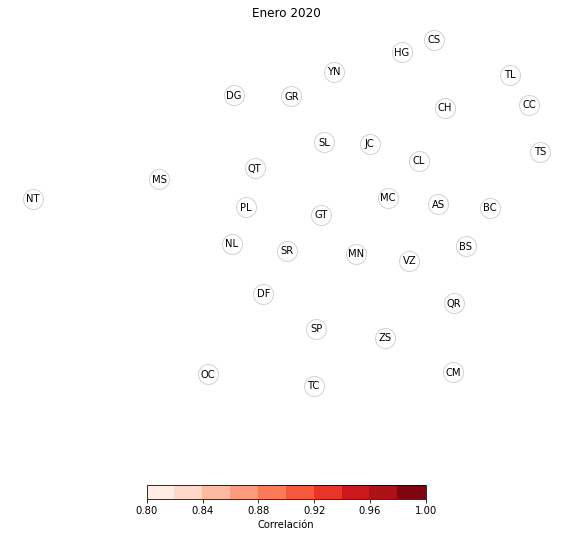

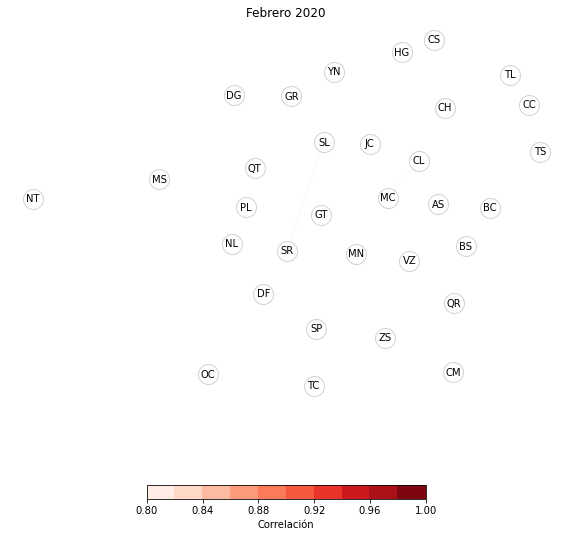

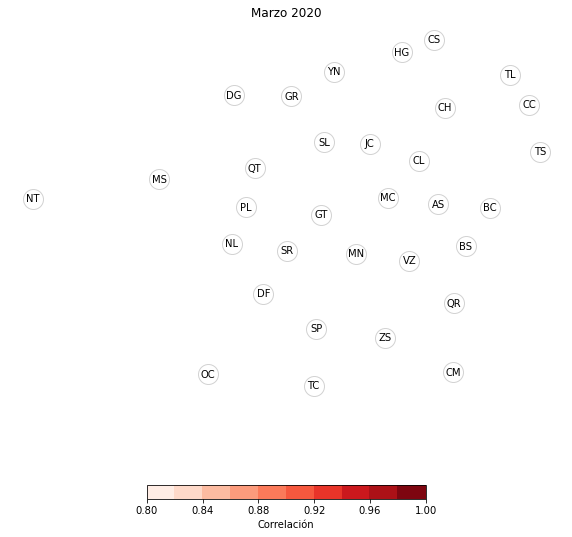

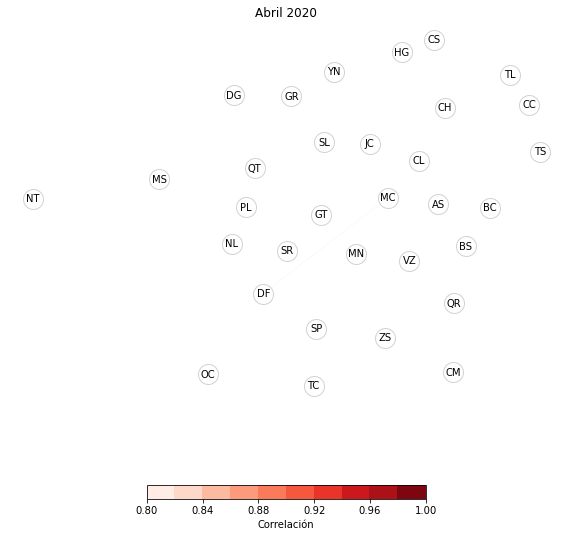

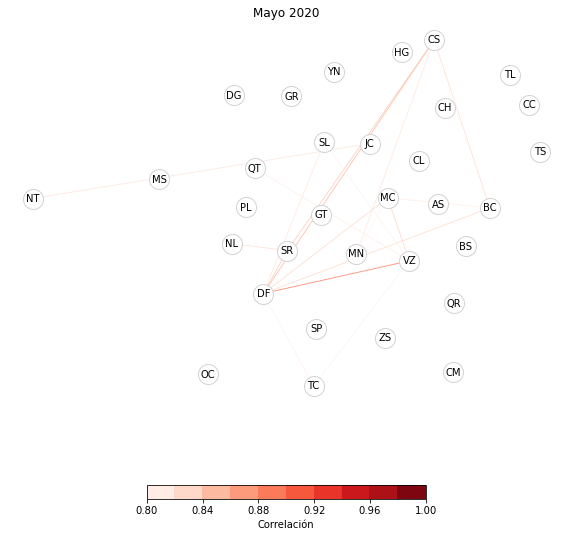

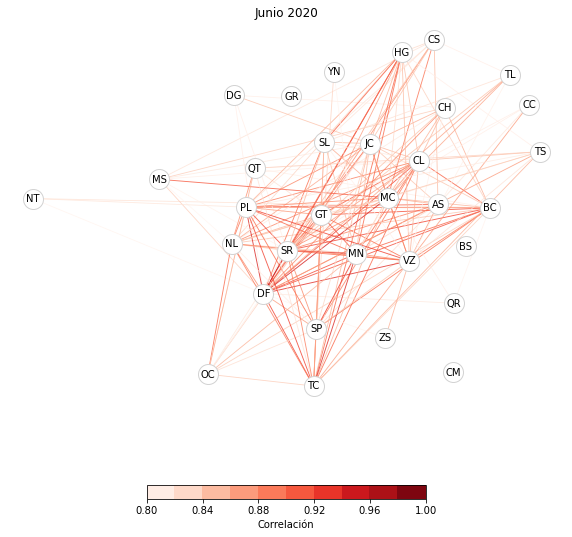

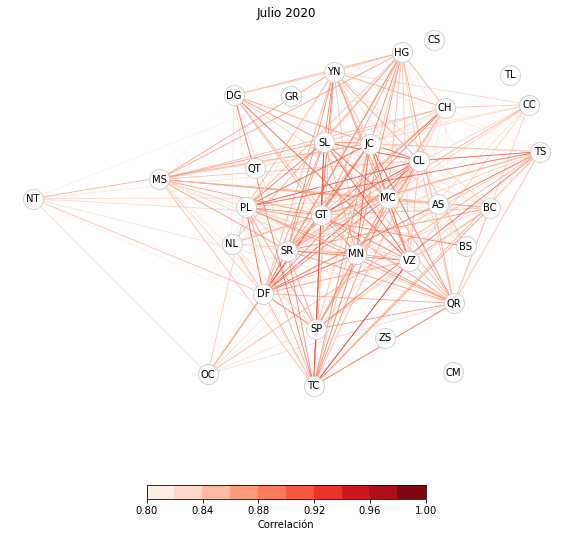

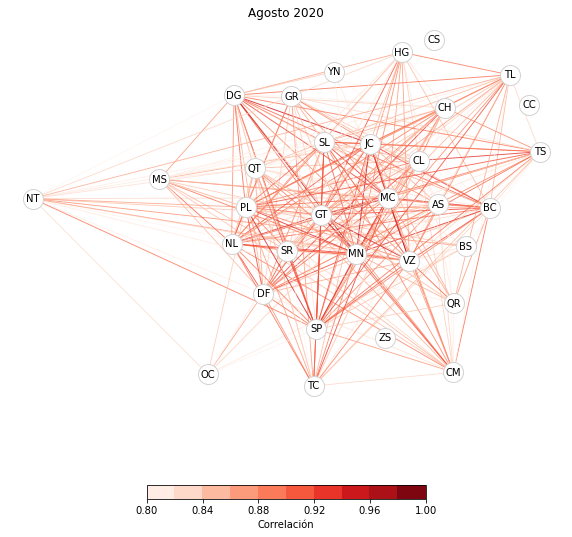

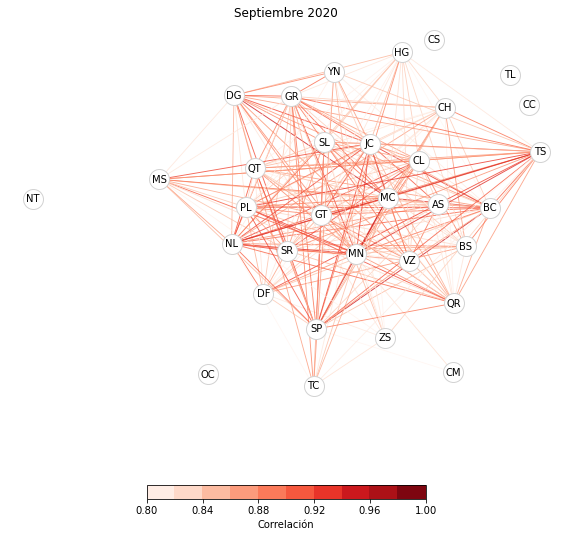

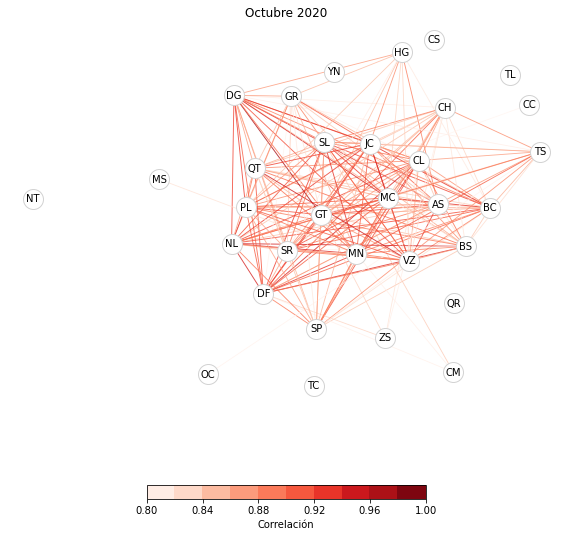

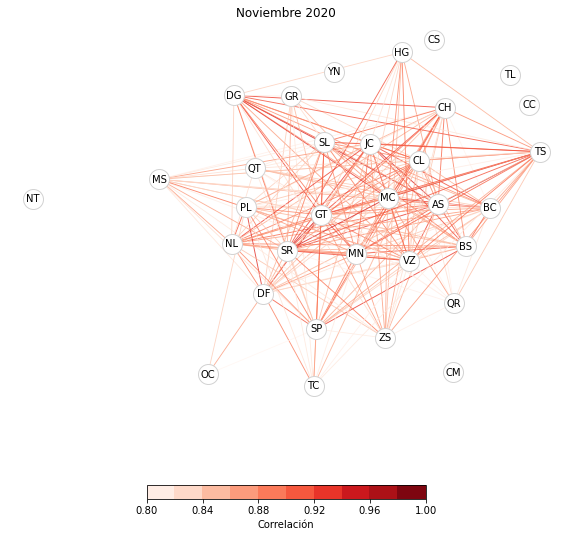

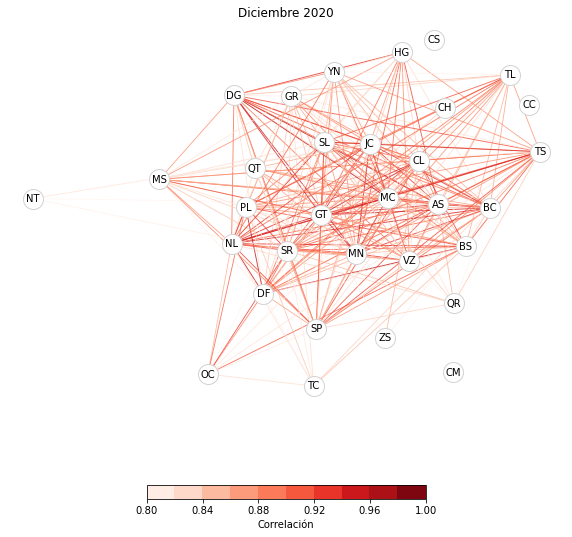

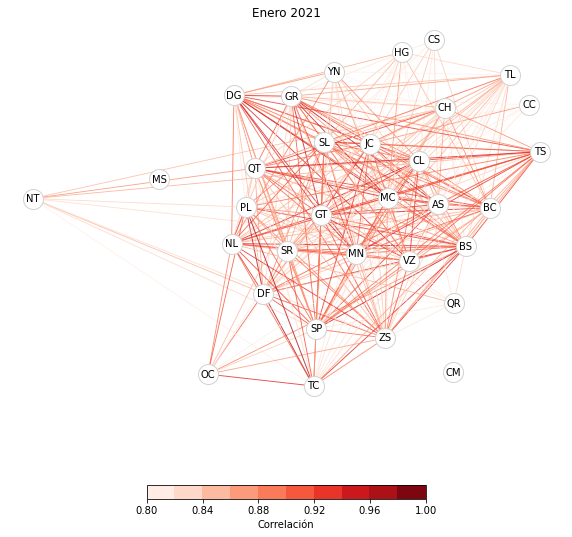

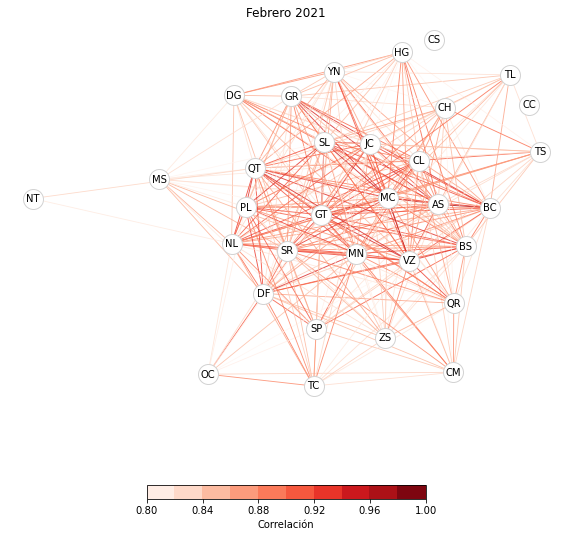

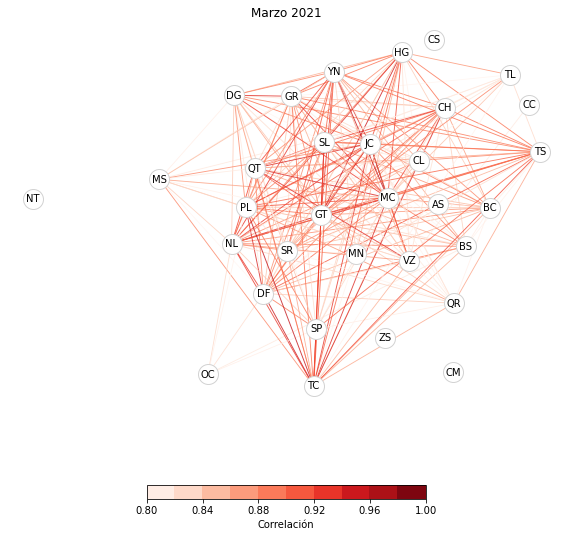

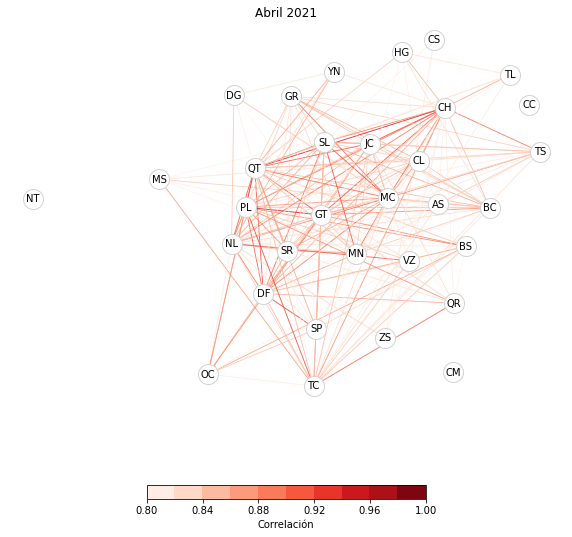

In [17]:
if guardar:
    dimensiones = (20, 20)
else:
    dimensiones = (10, 10)

# Fijamos posiciones de los nodos (usamos como referencia la red de febrero de 2021):
posiciones = nx.kamada_kawai_layout(redes[(2021, 2)])

# Iterar sobre el diccionario que contiene las redes y dibujarlas:
for periodo in redes.keys():
    fig, ax = plt.subplots(1, 1, figsize = dimensiones)
    pesos = [redes[periodo][i][j]['weight'] for (i, j) in redes[periodo].edges()]
    pesos_normalizados = [peso / max(pesos) for peso in pesos]
    
    # Gráfico de los edges:
    nx.draw_networkx_edges(
        redes[periodo],
        pos = posiciones,
        edge_color = pesos_normalizados,
        edge_cmap = plt.cm.Reds,
        alpha = 0.8,
        width = pesos_normalizados
    )
    # Gráfico de los nodos:
    nx.draw_networkx_nodes(
        redes[periodo],
        node_color = 'white',
        node_size = 400,
        pos = posiciones
    ).set_edgecolor('lightgray')
    # Gráfico de las etiquetas de nodos:
    nx.draw_networkx_labels(
        redes[periodo],
        font_size = 10,
        pos = posiciones
    )
    # Escala de colores:
    plt.colorbar(barra, ax = ax, shrink = 0.5, orientation = 'horizontal', label = 'Correlación')
    # Título del gráfico:
    plt.title(nombres_meses[periodo[1]] + ' ' + str(periodo[0]))
    ax.set_axis_off()
    # Guardar:
    if guardar:
        plt.savefig(f'figuras/{periodo[0]}-{periodo[1]}.png')

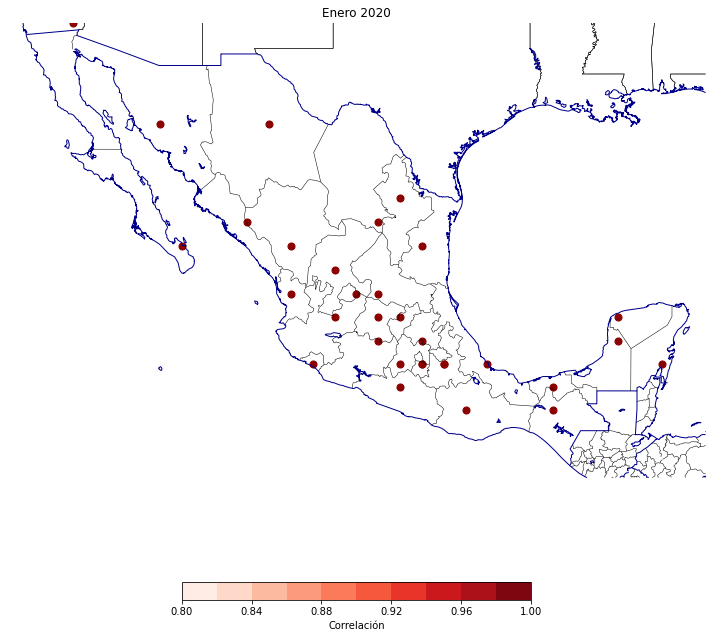

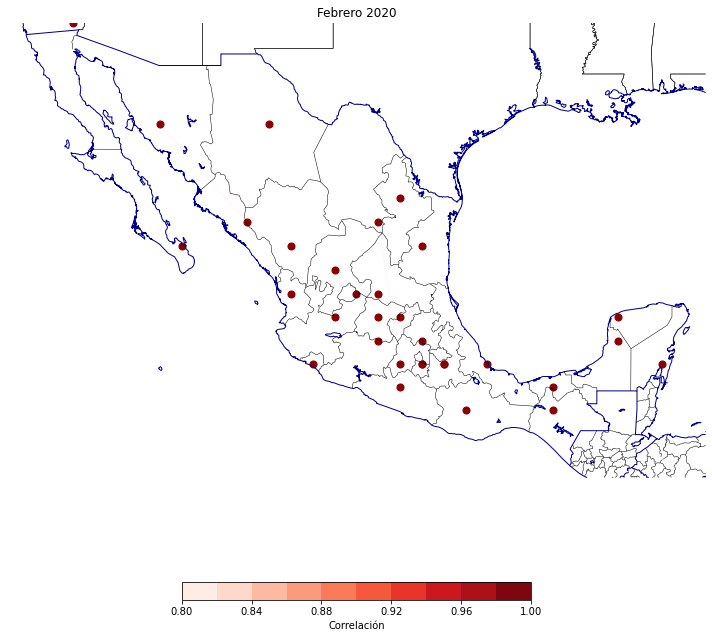

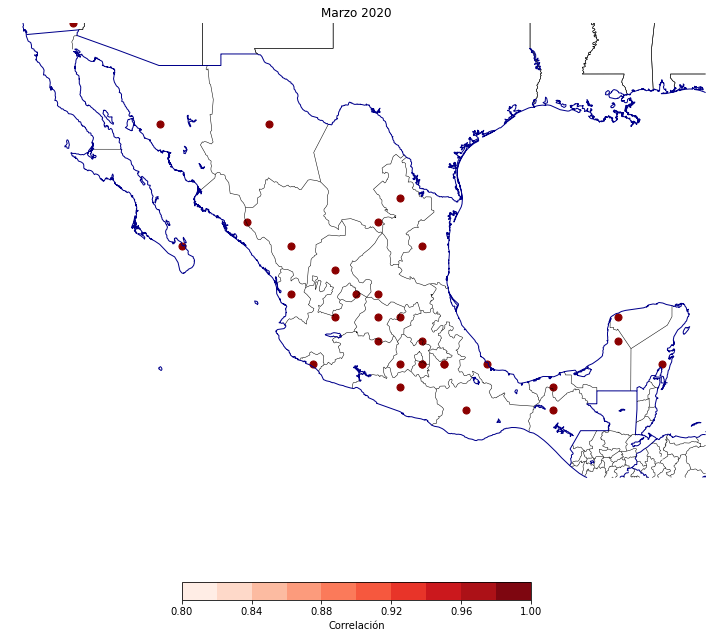

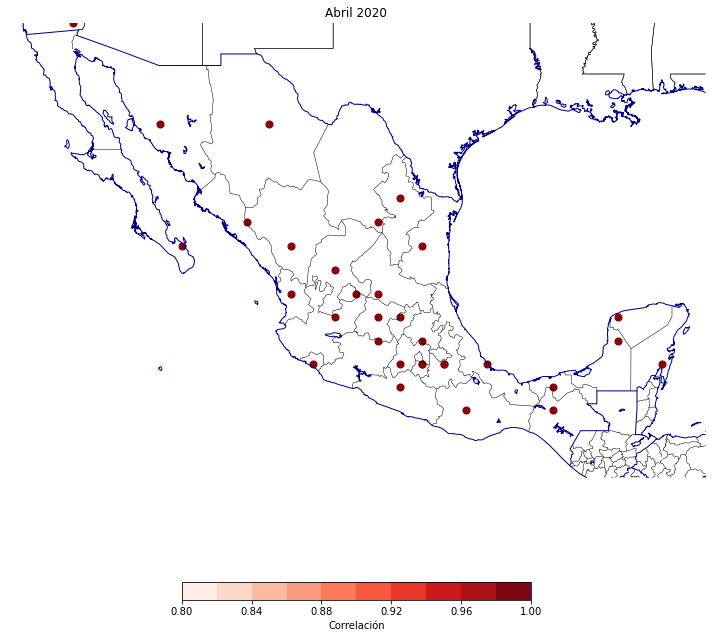

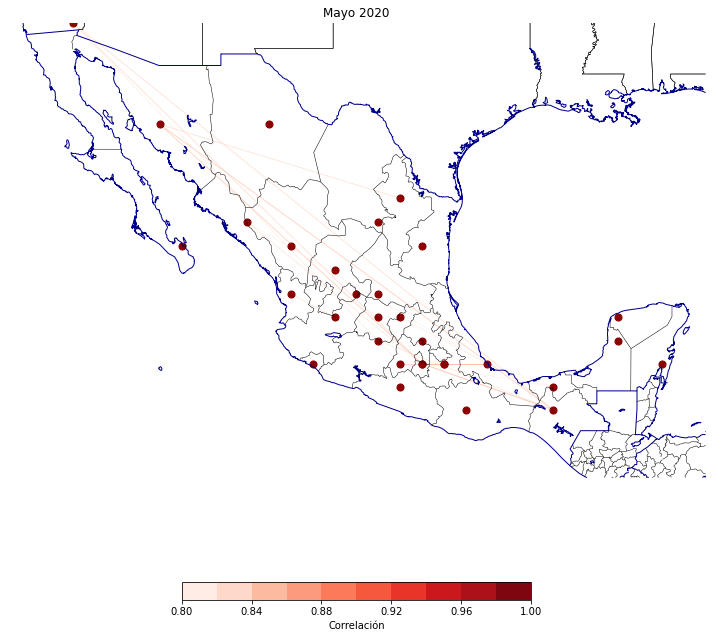

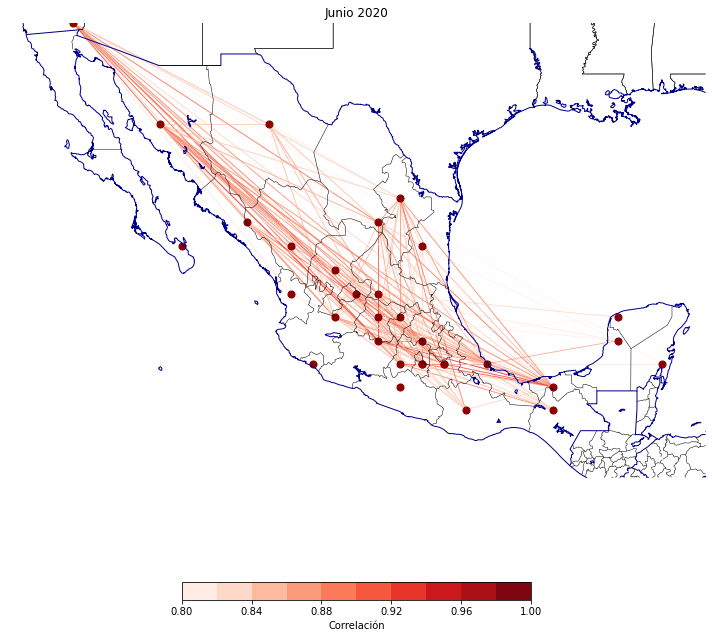

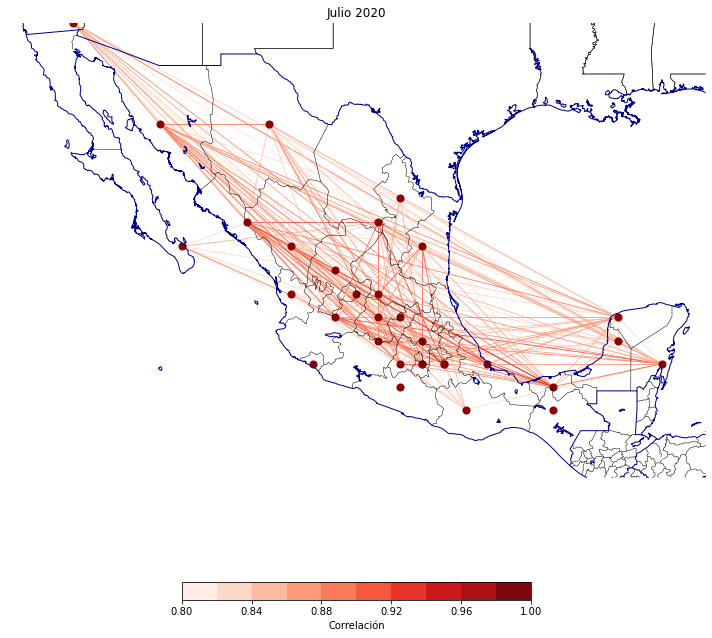

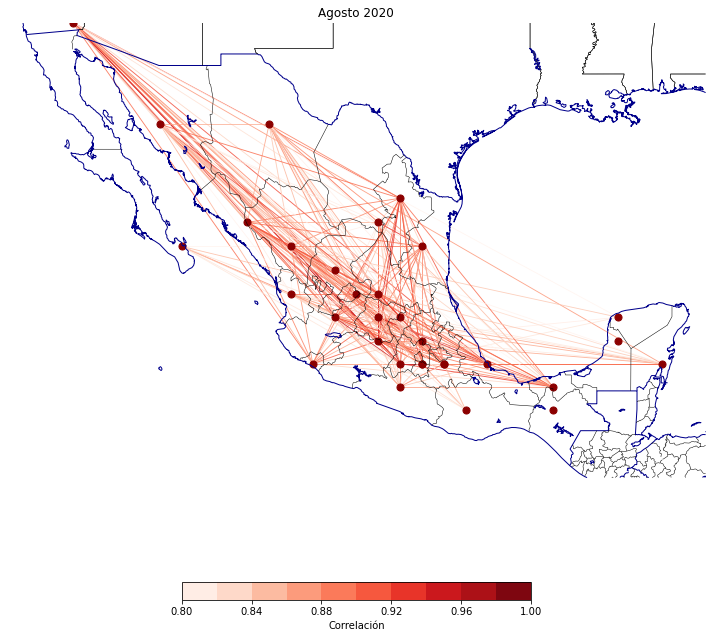

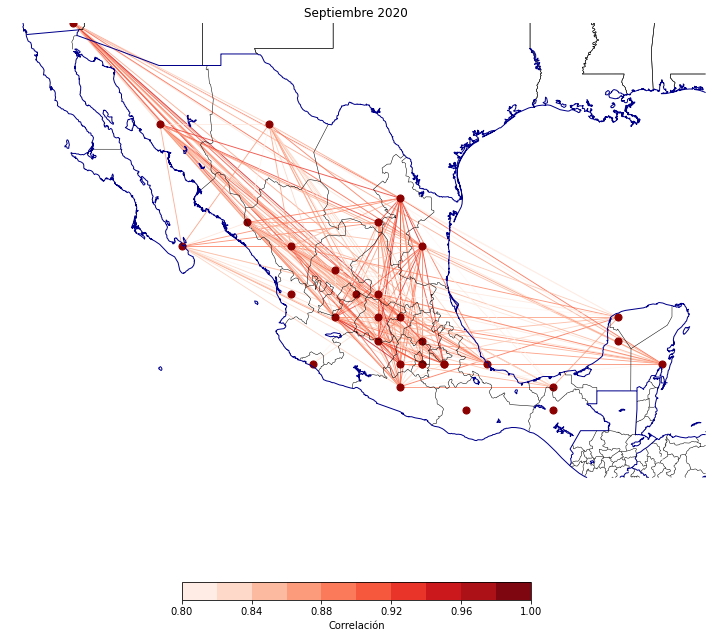

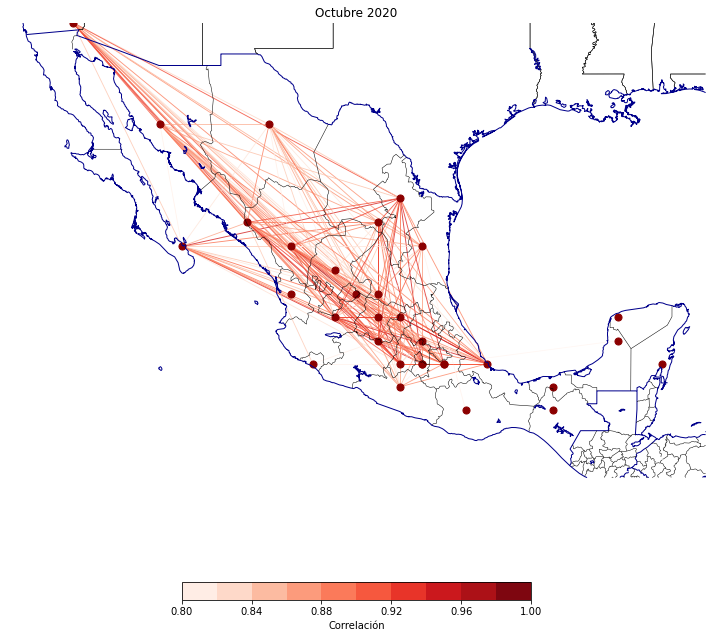

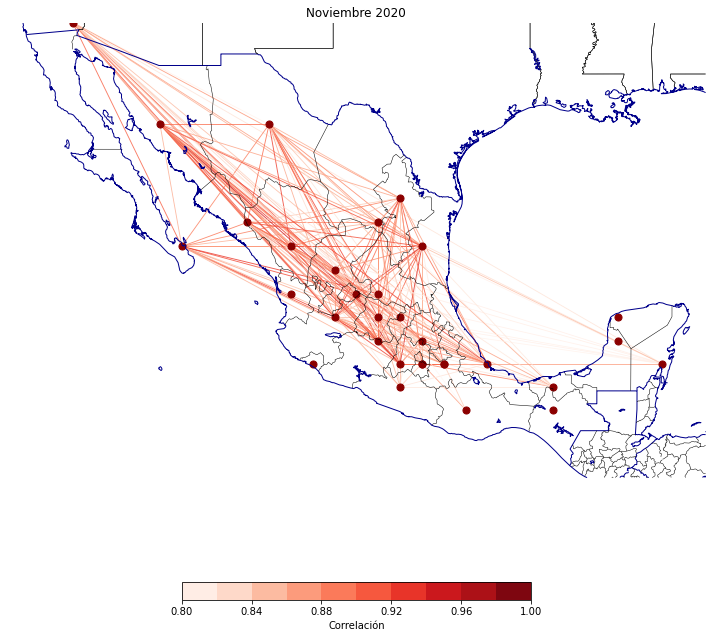

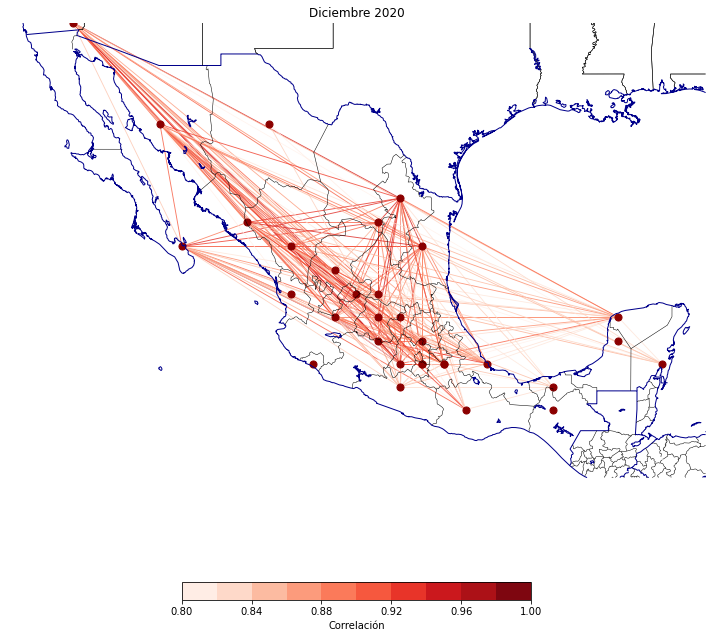

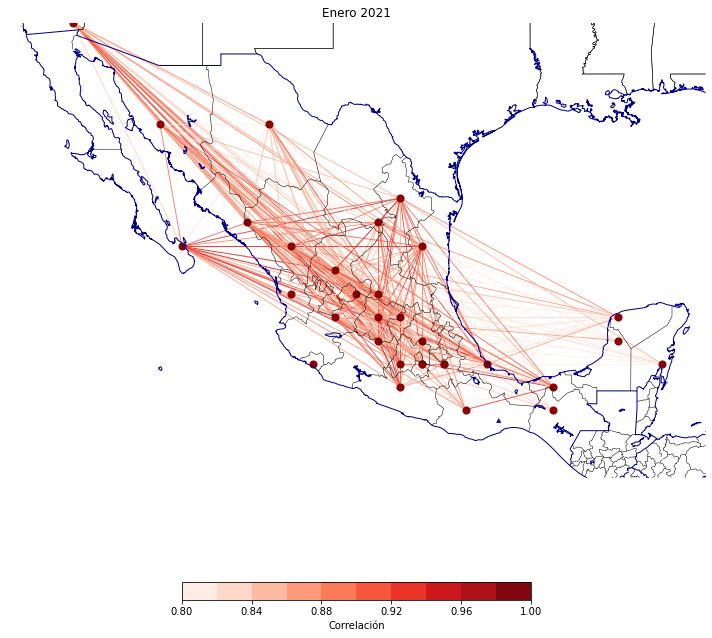

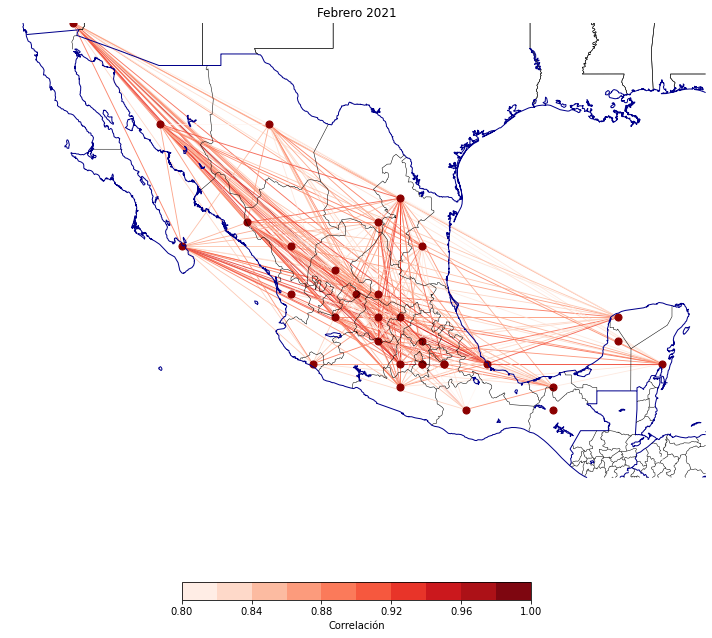

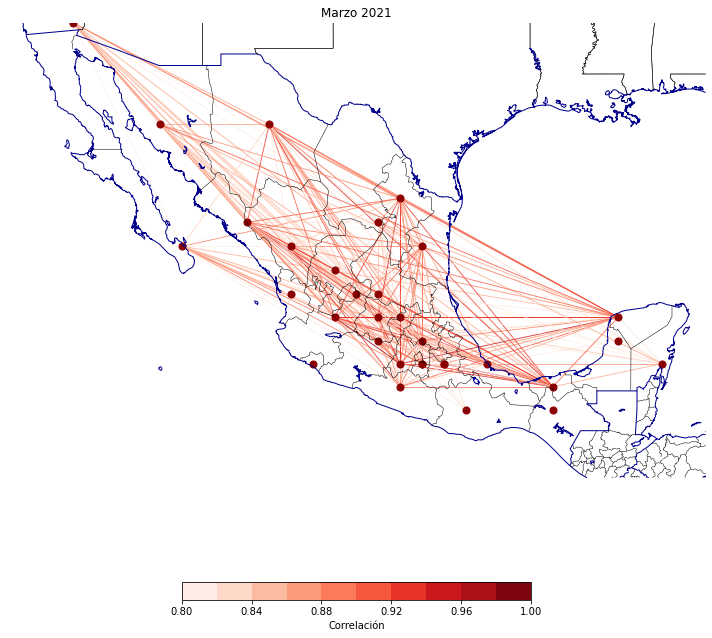

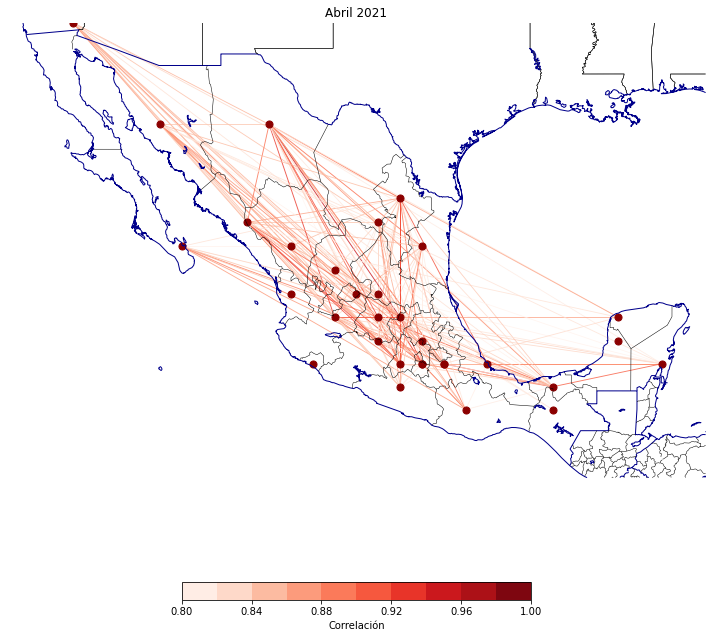

In [160]:
if guardar:
    dimensiones = (20, 20)
else:
    dimensiones = (10, 10)

# Objeto Basemap (mapa de México)
m = Basemap(
    projection = 'merc',
    llcrnrlon = -118,
    llcrnrlat = 14,
    urcrnrlon = -86,
    urcrnrlat = 33,
    lat_ts = 0,
    resolution = 'i',
    suppress_ticks = True
)

# Fijamos posiciones de los nodos (proyección sobre el objeto Basemap anterior):
posiciones = {mapping[i]['clave']: m(mapping[i]['lon'], mapping[i]['lat']) for i in mapping}

# Iterar sobre el diccionario que contiene las redes y dibujarlas:
for periodo in redes.keys():
    fig, ax = plt.subplots(1, 1, figsize = dimensiones)
    pesos = [redes[periodo][i][j]['weight'] for (i, j) in redes[periodo].edges()]
    pesos_normalizados = [peso / max(pesos) for peso in pesos]
    
    # Gráfico de los edges:
    nx.draw_networkx_edges(
        redes[periodo],
        pos = posiciones,
        edge_color = pesos_normalizados,
        edge_cmap = plt.cm.Reds,
        alpha = 0.8,
        width = pesos_normalizados
    )
    # Gráfico de los nodos:
    nx.draw_networkx_nodes(
        redes[periodo],
        node_color = 'darkred',
        node_size = 50,
        pos = posiciones
    )
    # Dibujar elementos del mapa:
    m.drawcountries(linewidth = 1, color = 'darkblue')
    m.drawstates(linewidth = 0.5)
    m.drawcoastlines(linewidth=1, color = 'darkblue')
    # Escala de colores:
    plt.colorbar(barra, ax = ax, shrink = 0.5, orientation = 'horizontal', label = 'Correlación')
    # Título del gráfico:
    plt.title(nombres_meses[periodo[1]] + ' ' + str(periodo[0]))
    ax.set_axis_off()
    plt.tight_layout()
    # Guardar:
    if guardar:
        plt.savefig(f'figuras/mapa-{periodo[0]}-{periodo[1]}.png')

In [63]:
#E_{t}
#Creamos un vector de fechas 

from datetime import datetime

date = pd.date_range(start='1/1/2020', end = '4/1/2021', freq='MS')

propiedades = pd.DataFrame({'date' : date})

propiedades_2 =pd.DataFrame(periodos)
propiedades=propiedades.merge(propiedades_2, left_index = True, right_index =True )

#Calculamos el número de ejes y lo añadimos al data frame por fecha

for periodo in periodos:
    if (periodo)[0] == 2020:
        j = (periodo)[1]
        propiedades.loc[j-1,"E"] = redes[periodo].number_of_edges()
    else :
        j = (periodo)[1]+11
        propiedades.loc[j,"E"] = redes[periodo].number_of_edges()

In [65]:
#D_{t}

propiedades['D']=propiedades['E']/496

In [71]:
#C_{t}

for periodo in periodos:
    if (periodo)[0] == 2020:
        j = (periodo)[1]
        propiedades.loc[j-1,"C"] = nx.average_clustering(redes[periodo])
    else :
        j = (periodo)[1]+11
        propiedades.loc[j,"C"] = nx.average_clustering(redes[periodo])

[Text(0, 0.5, 'Número de ejes'), Text(0.5, 0, 'Fecha')]

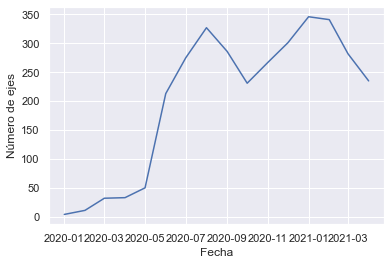

In [85]:
#Plot E_{t}
import seaborn as sns
sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="date",y="E",data=propiedades)

fig.set(xlabel ='Fecha',ylabel = "Número de ejes")

[Text(0, 0.5, 'Densidad'), Text(0.5, 0, 'Fecha')]

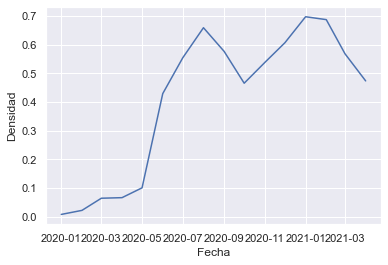

In [87]:
#Plot D_{t}
import seaborn as sns
sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="date",y="D",data=propiedades)

fig.set(xlabel ='Fecha',ylabel = "Densidad")

[Text(0, 0.5, 'Clustering average cofficient'), Text(0.5, 0, 'Fecha')]

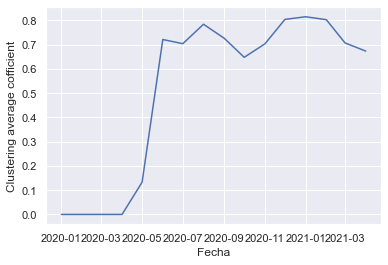

In [88]:
#Plot C_{t}
import seaborn as sns
sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="date",y="C",data=propiedades)

fig.set(xlabel ='Fecha',ylabel = "Clustering average cofficient") 